# Water–Sanitation Compass: Data-Driven Rankings and Costed Plans

- **pandas / numpy** – load your dataset and do fast numeric ops.
- **StandardScaler** – standardize features (zero mean, unit variance) so no single feature dominates.
- **KMeans** – centroid-based clustering to split countries into \(k\) similar groups.
- **PCA** – linear dimensionality reduction (often to 2D) for quick visualization/denoising.
- **matplotlib.pyplot** – plotting the scatter charts of embeddings/clusters.
- **UMAP** – non-linear dimensionality reduction to 2D/3D for tighter, structure-preserving visuals.
- **DBSCAN** – density-based clustering that finds arbitrary-shaped clusters and marks sparse points as noise (no need to pick \(k\)).

In [577]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import os

### Data sources

We use the **Natural Resource Protection and Child Health Indicators (NRPI & CHI), 2023 Release** compiled by the **Center for International Earth Science Information Network (CIESIN), Columbia University** (NASA SEDAC).

- **What’s included:**  
  - CHI constituent indicators for **2010–2022**: at least basic access to **water**, at least basic **sanitation**, and **child mortality** rates.  
  - NRPI scores for **2019–2022** (proximity-to-target, 0–100).

- **Suggested citation:**  
  *Center for International Earth Science Information Network (CIESIN), Columbia University. 2023. Natural Resource Protection and Child Health Indicators, 2023 Release. Palisades, New York: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/hvgh-g750.*

- **Access note:**  
  The Excel workbook from CIESIN/SEDAC contains the series we loaded into `datasets/cmr.csv` (CHI-related time series) and `datasets/nrpi.csv` (NRPI 2019–2022).


In [578]:
cmr = pd.read_csv("datasets/cmr.csv")
nrpi = pd.read_csv("datasets/nrpi.csv")

print(cmr.head())
print(nrpi.head())

  ISO3V10 Country_Territory_Island  CMR_10  CMR_11  CMR_12  CMR_13  CMR_14  \
0     AFG              Afghanistan   25.20   23.66   22.18   20.77   19.41   
1     ALB                  Albania    1.44    1.33    1.24    1.16    1.10   
2     DZA                  Algeria    4.02    3.91    3.83    3.77    3.71   
3     ASM           American Samoa     NaN     NaN     NaN     NaN     NaN   
4     AND                  Andorra    0.34    0.30    0.27    0.24    0.21   

   CMR_15  CMR_16  CMR_17  ...  CHI_v2023_13  CHI_v2023_14  CHI_v2023_15  \
0   18.14   17.01   15.99  ...         56.22         58.33         60.42   
1    1.07    1.05    1.04  ...         95.91         96.23         96.52   
2    3.66    3.61    3.54  ...         91.58         91.64         91.69   
3     NaN     NaN     NaN  ...           NaN           NaN           NaN   
4    0.18    0.16    0.15  ...         99.89         99.90         99.92   

   CHI_v2023_16  CHI_v2023_17  CHI_v2023_18  CHI_v2023_19  CHI_v2023_20  \

We will normalize the data for us to work with easier. 

In [579]:
def rename_year_cols(df):
    new_cols = {}
    for col in df.columns:
        if "_" in col and col.split("_")[-1].isdigit():
            year = col.split("_")[-1]
            if len(year) == 2:
                year = "20" + year
            new_cols[col] = "_".join(col.split("_")[:-1]) + "_" + year
    return df.rename(columns=new_cols)

cmr = rename_year_cols(cmr)
nrpi = rename_year_cols(nrpi)

print(cmr.head())
print(nrpi.head())

  ISO3V10 Country_Territory_Island  CMR_2010  CMR_2011  CMR_2012  CMR_2013  \
0     AFG              Afghanistan     25.20     23.66     22.18     20.77   
1     ALB                  Albania      1.44      1.33      1.24      1.16   
2     DZA                  Algeria      4.02      3.91      3.83      3.77   
3     ASM           American Samoa       NaN       NaN       NaN       NaN   
4     AND                  Andorra      0.34      0.30      0.27      0.24   

   CMR_2014  CMR_2015  CMR_2016  CMR_2017  ...  CHI_v2023_2013  \
0     19.41     18.14     17.01     15.99  ...           56.22   
1      1.10      1.07      1.05      1.04  ...           95.91   
2      3.71      3.66      3.61      3.54  ...           91.58   
3       NaN       NaN       NaN       NaN  ...             NaN   
4      0.21      0.18      0.16      0.15  ...           99.89   

   CHI_v2023_2014  CHI_v2023_2015  CHI_v2023_2016  CHI_v2023_2017  \
0           58.33           60.42           62.45           64.44

Notice how we have many NAN values in our original dataset. We drop those as to not interfere with our clustering methods.

In [580]:
df_clean_cmr = cmr.dropna()

df_clean_nrpi = nrpi.dropna()

removed_cmr = cmr[~cmr["Country_Territory_Island"].isin(df_clean_cmr["Country_Territory_Island"])]
print("Removed from CMR (any NaN):")
print(removed_cmr["Country_Territory_Island"].tolist())

removed_nrpi = nrpi[~nrpi["Country_Territory_Island"].isin(df_clean_nrpi["Country_Territory_Island"])]
print("\nRemoved from NRPI (any NaN):")
print(removed_nrpi["Country_Territory_Island"].tolist())

Removed from CMR (any NaN):
['American Samoa', 'Aruba', 'Bermuda', 'Bonaire, Sint Eustatius and Saba', 'Cayman Islands', 'Croatia', 'Curacao', 'Falkland Islands', 'Faroe Islands', 'French Guiana', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guadeloupe', 'Guam', 'Hong Kong', 'Isle of Man', 'Kosovo', 'Liechtenstein', 'Macau', 'Martinique', 'Mayotte', 'New Caledonia', 'North Mariana Islands', 'Peurto Rico', 'Reunion', 'Saint Barthelemy', 'Saint Helena, Ascension', 'Saint Martin', 'Saint Pierre and Miquelon', 'Saudi Arabia', 'Sint Maarten', 'South Sudan', 'Tokelau', 'Turks and Caicos Islands', 'Virgin Islands (US)', 'Wallis and Futuna']

Removed from NRPI (any NaN):
[]


- Compute summary stats over time for each metric (CMR, WAT, SAN, CHI, NRPI): latest, mean, std, trend (slope), and % change.

- Merge the cleaned datasets so each country has all metrics.

- Create an extra flag, infra_gap = WAT_mean − SAN_mean, to spot imbalance.

- Save everything as one features table for clustering/analysis.

In [581]:
def feature_summary(df, prefix, years):
    cols = [f"{prefix}_{y}" for y in years if f"{prefix}_{y}" in df.columns]
    vals = df[cols]
    
    return pd.DataFrame({
        f"{prefix}_latest": vals.iloc[:, -1],
        f"{prefix}_mean": vals.mean(axis=1),
        f"{prefix}_std": vals.std(axis=1),
        f"{prefix}_trend": vals.apply(lambda row: np.polyfit(range(len(cols)), row, 1)[0], axis=1),
        f"{prefix}_pct_change": (vals.iloc[:, -1] - vals.iloc[:, 0]) / vals.iloc[:, 0] * 100
    })

years = range(2010, 2023)
merged = df_clean_cmr.merge(df_clean_nrpi, on="Country_Territory_Island", how="left")

cmr_feat = feature_summary(merged, "CMR", years)
wat_feat = feature_summary(merged, "WAT", years)
san_feat = feature_summary(merged, "SAN", years)
chi_feat = feature_summary(merged, "CHI_v2023", years)

nrpi_feat = feature_summary(merged, "NRPI_v2023", range(2019, 2023))

infra_gap = (wat_feat["WAT_mean"] - san_feat["SAN_mean"]).rename("infra_gap")

features = pd.concat([
    merged[["ISO3V10", "Country_Territory_Island"]],
    cmr_feat, wat_feat, san_feat, chi_feat, nrpi_feat, infra_gap
], axis=1)

features.to_csv("datasets/engineered_features.csv", index=False)



## K-Means Clustering
- **Load features** from `engineered_features.csv`.
- **Drop IDs** and **exclude NRPI_* columns** so clustering uses CMR/WAT/SAN/CHI + derived stats only.
- **Standardize** all features with `StandardScaler` (zero mean, unit variance).
- **Cluster** countries using `KMeans` with `k=5` clusters (`random_state=42` for reproducibility).
- **Visualize** the clusters by projecting scaled data to 2D with **PCA** and coloring points by cluster.
- **Print membership**: list the countries in each KMeans cluster.
- **Summarize clusters**: print per-cluster averages of all numeric features.

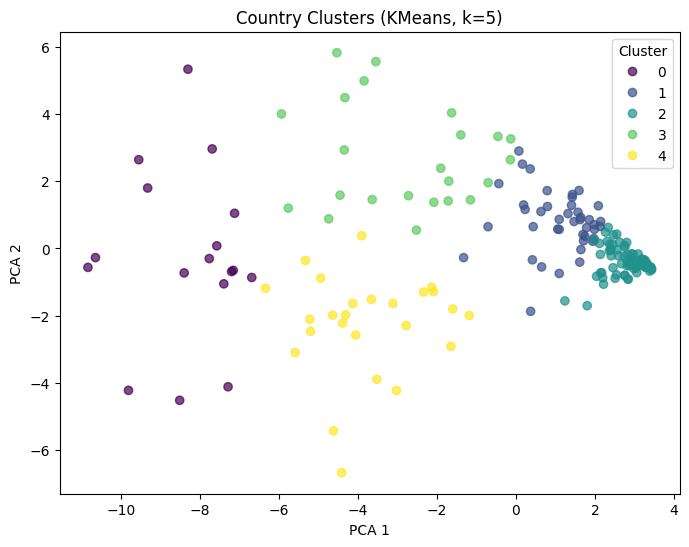


Cluster 0: (17 countries)
['Afghanistan', 'Angola', 'Burkina Faso', 'Chad', 'Ethiopia', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Malawi', 'Mali', 'Mozambique', 'Niger', 'Nigeria', 'Sierra Leone', 'Somalia', 'Tanzania', 'Uganda']

Cluster 1: (42 countries)
['Azerbaijan', 'Belize', 'Brazil', 'Brunei Darussalam', 'Colombia', "Democratic People's Republic of Korea", 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Guyana', 'Honduras', 'Iran', 'Iraq', 'Kyrgyzstan', 'Lebanon', 'Libya', 'Lithuania', 'Maldives', 'Mexico', 'Montenegro', 'Morocco', 'Nicaragua', 'Palestine', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Republic of Moldova', 'Romania', 'Saint Vincent and the Grenadines', 'Samoa', 'South Africa', 'Sri Lanka', 'Suriname', 'Syrian Arab Republic', 'Tajikistan', 'Tunisia', 'Turkey', 'Turkmenistan', 'Vanuatu']

Cluster 2: (88 countries)
['Albania', 'Algeria', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Bahamas', '

In [ ]:
df = pd.read_csv("datasets/engineered_features.csv")
X = df.drop(columns=["ISO3V10", "Country_Territory_Island"])
X = X[[col for col in X.columns if not col.startswith("NRPI_")]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df["Cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Country Clusters (KMeans, k=5)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

for cluster_id, group in df.groupby("Cluster"):
    print(f"\nCluster {cluster_id}: ({len(group)} countries)")
    print(group["Country_Territory_Island"].tolist())

print("\n=== Cluster Feature Averages ===")
cluster_means = df.groupby("Cluster")[X.columns].mean().round(2)
print(cluster_means)


## UMAP Visualization

- **Visualize with UMAP**  
  - Compute a 2D UMAP embedding (`n_neighbors=15`, `min_dist=0.05`) on the scaled features.  
  - Plot the embedding, coloring points by their KMeans cluster.

- **Inspect results**  
  - Print the list of countries in each cluster.  
  - Print **cluster feature averages** to see what characterizes each group.


/Users/kelvin/NASA_Space_Apps_Challenge_Fall_2025/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


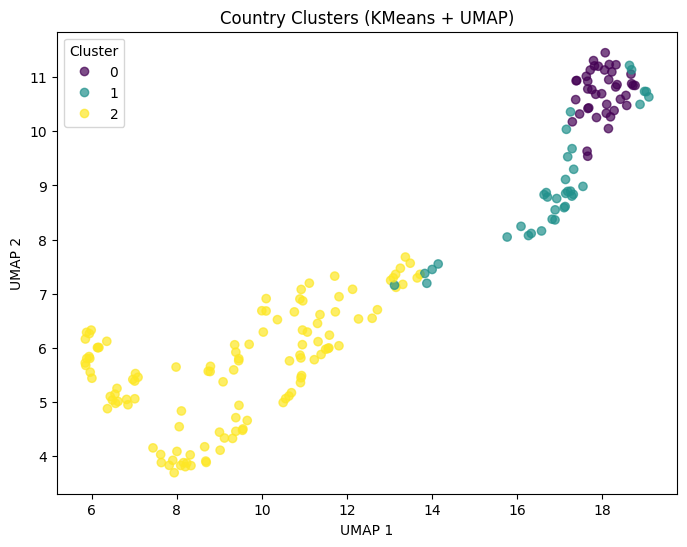


Cluster 0: (40 countries)
['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Congo', "Cote d'Ivoire", 'Democratic Republic of the Congo', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Niger', 'Nigeria', 'Papua New Guinea', 'Senegal', 'Sierra Leone', 'Somalia', 'Sudan', 'Tanzania', 'Togo', 'Uganda', 'Zambia', 'Zimbabwe']

Cluster 1: (37 countries)
['Azerbaijan', 'Bangladesh', 'Bhutan', 'Bolivia', 'Botswana', 'Cabo Verde', 'Cambodia', 'China', 'Comoros', 'Djibouti', 'Ecuador', 'Gabon', 'Honduras', 'India', 'Indonesia', 'Iraq', 'Kiribati', "Lao People's Democratic Republic", 'Micronesia (Federated States of)', 'Mongolia', 'Morocco', 'Myanmar', 'Namibia', 'Nepal', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Rwanda', 'Sao Tome and Principe', 'Solomon Islands', 'S

In [ ]:
df = pd.read_csv("datasets/engineered_features.csv")

X = df.drop(columns=["ISO3V10", "Country_Territory_Island"])
X = X[[col for col in X.columns if not col.startswith("NRPI_")]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)
umap_model = umap.UMAP(n_neighbors=15, min_dist=.05, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_umap[:,0], X_umap[:,1], c=df["Cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Country Clusters (KMeans + UMAP)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

for cluster_id, group in df.groupby("Cluster"):
    print(f"\nCluster {cluster_id}: ({len(group)} countries)")
    print(group["Country_Territory_Island"].tolist())

print("\n=== Cluster Feature Averages ===")
cluster_means = df.groupby("Cluster")[X.columns].mean().round(2)
print(cluster_means)


## DBSCAN Clustering

- **Visualize** the UMAP scatter colored by DBSCAN labels.

- **Inspect results**:
  - Print the list of countries per cluster (including noise).
  - Print **per-cluster feature averages** to understand what differentiates clusters.

/Users/kelvin/NASA_Space_Apps_Challenge_Fall_2025/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


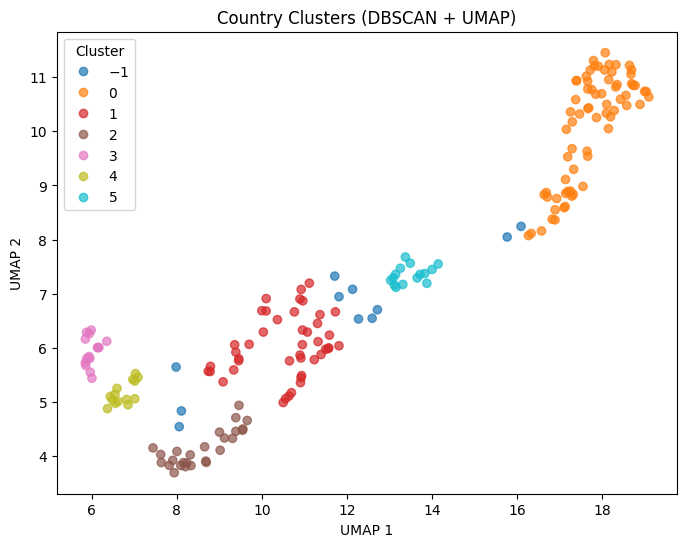


Cluster -1: (11 countries)
['Algeria', 'El Salvador', 'Guatemala', 'Libya', 'Morocco', 'Nicaragua', 'Poland', 'Romania', 'Samoa', 'Tajikistan', 'Ukraine']

Cluster 0: (70 countries)
['Afghanistan', 'Angola', 'Azerbaijan', 'Bangladesh', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'China', 'Comoros', 'Congo', "Cote d'Ivoire", 'Democratic Republic of the Congo', 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'India', 'Indonesia', 'Iraq', 'Kenya', 'Kiribati', "Lao People's Democratic Republic", 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Micronesia (Federated States of)', 'Mongolia', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Papua New Guinea', 'Paraguay', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Somalia', 'S

In [584]:
# Load dataset
df = pd.read_csv("datasets/engineered_features.csv")

# Drop IDs and NRPI features
X = df.drop(columns=["ISO3V10", "Country_Territory_Island"])
X = X[[col for col in X.columns if not col.startswith("NRPI_")]]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- UMAP embedding ---
umap_model = umap.UMAP(n_neighbors=15, min_dist=.05, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# --- DBSCAN clustering ---
db = DBSCAN(eps=0.45, min_samples=5).fit(X_umap)
df["Cluster_DBSCAN"] = db.labels_

# --- Plot ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_umap[:,0], X_umap[:,1], c=df["Cluster_DBSCAN"], cmap="tab10", alpha=0.7)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Country Clusters (DBSCAN + UMAP)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

# --- Print countries per cluster ---
for cluster_id, group in df.groupby("Cluster_DBSCAN"):
    print(f"\nCluster {cluster_id}: ({len(group)} countries)")
    print(group["Country_Territory_Island"].tolist())
    
print("\n=== Cluster Feature Averages ===")
cluster_means = df.groupby("Cluster_DBSCAN")[X.columns].mean().round(2)
print(cluster_means)

Cluster A – High Wellbeing / Sustainable Systems:
High access to water & sanitation, low mortality.
→ Example: Cities with mature water infrastructure and environmental planning.

Cluster B – Infrastructure-Deficient / High Mortality:
Low access to water & sanitation, high child mortality.
→ Example: Rapidly urbanizing areas with strained or unequal infrastructure.

Cluster C – Moderate Infrastructure / Unexpected Mortality:
Reasonable infrastructure but high mortality (possible crime, conflict, or pollution).
→ Example: Cities with social instability or hidden environmental hazards.

## Need Score and Ranking

- **Load** engineered features and keep just `WAT_latest`, `SAN_latest`, `CMR_latest` + country.
- **Clean**: drop rows with missing values in those three fields.
- **Build a Need Score (0–1, higher = worse)**  
  - Scale each metric to 0–1 with `MinMaxScaler`.  
  - Compute: `Need = 0.4*(1−WAT) + 0.4*(1−SAN) + 0.2*(CMR)`.  
  - Intuition: low water/sanitation and high mortality push the score up.

- **Assign policy buckets** (simple rules):
  - **Type A – Maintain & Climate-proof:** `WAT ≥ 85`, `SAN ≥ 80`, `CMR ≤ 10`.
  - **Type B – Basic Services First:** at least **2** of {`WAT ≤ 70`, `SAN ≤ 60`, `CMR ≥ 15`}.
  - **Type C – Service Quality & Risk Control:** everything else (service exists but quality/risk issues).

- **Inspect results**:
  - Print counts per policy bucket.
  - Save a ranked table to `datasets/wash_need_ranked.csv`.
  - Print the **top-need** and **lowest-need** countries with their metrics and bucket.

In [585]:
df = pd.read_csv("datasets/engineered_features.csv")

use = df[["Country_Territory_Island","WAT_latest","SAN_latest","CMR_latest"]].copy()

use = use.dropna(subset=["WAT_latest","SAN_latest","CMR_latest"])

sc = MinMaxScaler()
Z = pd.DataFrame(sc.fit_transform(use[["WAT_latest","SAN_latest","CMR_latest"]]),
                 columns=["WAT","SAN","CMR"], index=use.index)

use["Need_Score_0to1"] = (0.4*(1-Z["WAT"]) + 0.4*(1-Z["SAN"]) + 0.2*(Z["CMR"])).round(3)

HI_WAT, HI_SAN, LOW_MORT = 85, 80, 10
LOW_WAT, LOW_SAN, HIGH_MORT = 70, 60, 15 

def bucket(row):
    W, S, C = row.WAT_latest, row.SAN_latest, row.CMR_latest
    if (W >= HI_WAT) and (S >= HI_SAN) and (C <= LOW_MORT):
        return "Type A: Maintain & Climate-proof"
    low_flags = int(W <= LOW_WAT) + int(S <= LOW_SAN) + int(C >= HIGH_MORT)
    if low_flags >= 2:
        return "Type B: Basic Services First"
    return "Type C: Service Quality & Risk Control"

use["Policy_Bucket"] = use.apply(bucket, axis=1)
print("\nCounts per policy bucket:")
print(use["Policy_Bucket"].value_counts())

ranked = use.sort_values("Need_Score_0to1", ascending=False)
ranked.to_csv("datasets/wash_need_ranked.csv", index=False)

want_cols = ["Country_Territory_Island","WAT_latest","SAN_latest","CMR_latest","Need_Score_0to1","Policy_Bucket"]
cols = [c for c in want_cols if c in ranked.columns]
n = min(15, len(ranked))

print("\n=== TOP NEED (highest Need_Score) ===")
print(ranked[cols].head(n).to_string(index=False))

print("\n=== LOWEST NEED (lowest Need_Score) ===")
print(ranked[cols].tail(n).iloc[::-1].to_string(index=False))


Counts per policy bucket:
Policy_Bucket
Type A: Maintain & Climate-proof          129
Type B: Basic Services First               34
Type C: Service Quality & Risk Control     32
Name: count, dtype: int64

=== TOP NEED (highest Need_Score) ===
        Country_Territory_Island  WAT_latest  SAN_latest  CMR_latest  Need_Score_0to1                Policy_Bucket
                           Niger       48.90       16.41       59.17            0.884 Type B: Basic Services First
        Central African Republic       36.30       13.85       26.49            0.862 Type B: Basic Services First
Democratic Republic of the Congo       35.12       16.17       17.69            0.829 Type B: Basic Services First
                            Chad       52.00       12.92       43.92            0.828 Type B: Basic Services First
                    Burkina Faso       49.51       24.76       32.52            0.753 Type B: Basic Services First
                        Ethiopia       51.51        9.34       12.

# Action Planning and Associated Costs

## 1) Load our inputs

## 2) Pull population (from OWID) and compute urban population
- Downloads two **Our World in Data** (OWID) “grapher” CSVs:
  - **Total population** by country (latest year per ISO3).
  - **Urban share of population** (%) by country (latest year).
- Auto-detects the right columns (OWID sometimes changes headers), then keeps the **latest non-missing** value per ISO3.
- Computes estimated **urban population**:

$$
\text{Pop\_urban\_est} = \text{Pop\_total} \times \frac{\text{Urban\_pct}}{100}
$$

- Merges these population fields onto `engineered_features.csv` via ISO3, and writes the enriched file to `datasets/engineered_features_with_pop.csv`.

## 3) Merge 
- Joins the enriched features onto `wash_need_ranked.csv` **by country name** while keeping ISO3 attached.
- If pandas creates suffixes (e.g., `_feat`) due to duplicate columns, it **prefers the non-null** version and drops the duplicate.
- Verifies the required columns exist after the merge:
  - `WAT_latest`, `SAN_latest`, `CMR_latest`, `Need_Score_0to1`, `Policy_Bucket`.

## 4) Set planning parameters 
- **Targets** (fractions, not percentages):
  - Water coverage target = `TARGET_WAT = 0.90` (90%)
  - Sanitation coverage target = `TARGET_SAN = 0.80` (80%)
- **Feasible 12-month gains** (maximum points added in 12 months):
  - Water: `MAX_PPTS_WAT_12M = 0.10` (i.e., up to +10 percentage points)
  - Sanitation: `MAX_PPTS_SAN_12M = 0.08` (i.e., up to +8 percentage points)
- **Delivery mix** (share of new water coverage from communal vs. household connections):
  - `WAT_COMMUNAL_SHARE = 0.5`, `WAT_HH_SHARE = 0.5`
- **Unit delivery assumptions** (how many people each asset serves):
  - 1 standpipe ≈ **250 people**
  - 1 basic/shared toilet ≈ **20 people**
  - 1 household connection ≈ **5 people** (assumed household size)
  - 1 handwashing station ≈ **5,000 people** (coverage at public sites)
  - Desludging: **4 trips / 1,000 people** per year in priority areas
- **Unit costs** (very rough global averages; change as needed):
  - Standpipe: **$1,500**
  - Basic toilet: **$300**
  - New HH water connection: **$400**
  - Handwashing station: **$200**
  - Desludging trip: **$50**
  - Chlorine/consumables: **$100 per 1,000 people** reached
- Fallback if population missing: `DEFAULT_URBAN_POP = 1,000,000`.

## 5) Quantify a 12-month plan per country
For each country:

1. **Current coverage** (as fractions):

$$
W = \frac{\text{WAT\_latest}}{100}, \quad S = \frac{\text{SAN\_latest}}{100}
$$

2. **Gaps to target**:

$$
\text{W\_gap} = \max(0, \text{TARGET\_WAT} - W), \quad 
\text{S\_gap} = \max(0, \text{TARGET\_SAN} - S)
$$

3. **Feasible gains in 12 months** (cap at max step):

$$
\text{W\_gain} = \min(\text{W\_gap}, \text{MAX\_PPTS\_WAT\_12M}), \quad 
\text{S\_gain} = \min(\text{S\_gap}, \text{MAX\_PPTS\_SAN\_12M})
$$

4. **People to reach** using **urban pop**:

$$
\text{People\_new\_WAT\_12m} \approx \text{W\_gain} \times \text{Pop\_urban\_est}, \quad
\text{People\_new\_SAN\_12m} \approx \text{S\_gain} \times \text{Pop\_urban\_est}
$$

5. **Translate people → assets** (rounding up):

- Standpipes:
$$
\left\lceil \frac{\text{People\_new\_WAT\_12m} \times \text{WAT\_COMMUNAL\_SHARE}}{250} \right\rceil
$$

- New HH connections:
$$
\left\lceil \frac{\text{People\_new\_WAT\_12m} \times \text{WAT\_HH\_SHARE}}{5} \right\rceil
$$

- Basic toilets:
$$
\left\lceil \frac{\text{People\_new\_SAN\_12m}}{20} \right\rceil
$$

- Handwashing stations:
$$
\left\lceil \frac{\max(\text{People\_new\_WAT\_12m}, \text{People\_new\_SAN\_12m})}{5000} \right\rceil
$$

- Desludging trips (per year):
$$
\left\lceil \frac{\max(\text{People\_new\_WAT\_12m}, \text{People\_new\_SAN\_12m})}{1000} \times 4 \right\rceil
$$

6. **Cost the 12-month package** using the unit costs above.

7. Attach a **policy package** template based on `Policy_Bucket`:
   - **Type B:** “Basic Services First” (rapid coverage expansion)
   - **Type C:** “Service Quality & Risk Control” (continuity, safety, exposure reduction)
   - **Type A:** “Maintain & Climate-proof” (keep high levels, resilience, equity sweep)

## 6) Save outputs
- `datasets/engineered_features_with_pop.csv` — Our features + population fields.
- `datasets/wash_need_ranked.csv` — updated ranked table (unchanged logic, now with population).
- `datasets/wash_plan_12m_quantified.csv` — **master plan** with per-country counts & costs.
- `datasets/policy_book_WASH.csv` — a clean, presentation-ready subset of columns.
- `datasets/briefs/*.md` — one **markdown brief per country** (owners, actions, quantities, cost, KPIs, timelines).

In [ ]:
def norm_cols(df):
    df = df.copy()
    df.columns = [c.strip().replace("\xa0"," ").replace("\u200b","").strip() for c in df.columns]
    return df

def owid_latest_by_code(url: str) -> pd.DataFrame:
    df = pd.read_csv(url)
    df = norm_cols(df)
    lower = {c: c.lower() for c in df.columns}
    df.rename(columns=lower, inplace=True)

    iso_col = "code" if "code" in df.columns else ("iso_code" if "iso_code" in df.columns else None)
    year_col = "year" if "year" in df.columns else None
    candidate_value_cols = [c for c in df.columns if c not in {"entity", "code", "iso_code", "year"}]
    if not iso_col or not year_col or not candidate_value_cols:
        raise RuntimeError(f"OWID schema unexpected for {url}. Columns: {df.columns.tolist()}")
    val_col = candidate_value_cols[0]
    df = df[[iso_col, year_col, val_col]].dropna(subset=[iso_col])
    df = df.sort_values([iso_col, year_col])
    latest = df.dropna(subset=[val_col]).groupby(iso_col, as_index=False).tail(1)
    latest.rename(columns={iso_col: "ISO3V10", val_col: "value"}, inplace=True)
    return latest[["ISO3V10", "value"]]

ranked = norm_cols(pd.read_csv("datasets/wash_need_ranked.csv"))
feat   = norm_cols(pd.read_csv("datasets/engineered_features.csv"))

OWID_POP_URL   = "https://ourworldindata.org/grapher/population.csv"
OWID_URBAN_URL = "https://ourworldindata.org/grapher/share-of-population-urban.csv"

pop_latest   = owid_latest_by_code(OWID_POP_URL)      
urban_latest = owid_latest_by_code(OWID_URBAN_URL)    

wb_pop = pop_latest.rename(columns={"value":"Pop_total"}).merge(
    urban_latest.rename(columns={"value":"Urban_pct"}),
    on="ISO3V10", how="outer"
)

for col in ["Pop_total","Urban_pct"]:
    wb_pop[col] = pd.to_numeric(wb_pop[col], errors="coerce")

wb_pop["Pop_urban_est"] = np.where(
    wb_pop["Pop_total"].notna() & wb_pop["Urban_pct"].notna(),
    (wb_pop["Pop_total"] * (wb_pop["Urban_pct"]/100.0)).round(0),
    np.nan
).astype("int")

feat = feat.merge(wb_pop, on="ISO3V10", how="left")
os.makedirs("datasets", exist_ok=True)
feat.to_csv("datasets/engineered_features_with_pop.csv", index=False)

wash_cols = ["Country_Territory_Island","WAT_latest","SAN_latest","CMR_latest"]
missing_in_feat = [c for c in wash_cols if c not in feat.columns]
if missing_in_feat:
    raise RuntimeError(f"engineered_features.csv is missing columns: {missing_in_feat}")

tmp = ranked.merge(
    feat[["ISO3V10"] + wash_cols + ["Pop_total","Urban_pct","Pop_urban_est"]],
    on="Country_Territory_Island", how="left", suffixes=("","_feat")
)

for col in ["WAT_latest","SAN_latest","CMR_latest"]:
    alt = f"{col}_feat"
    if alt in tmp.columns:
        if col not in tmp.columns or tmp[col].isna().all():
            tmp[col] = tmp[alt]
        tmp.drop(columns=[alt], inplace=True, errors="ignore")

required = ["Country_Territory_Island","Policy_Bucket","Need_Score_0to1","WAT_latest","SAN_latest","CMR_latest"]
for c in required:
    if c not in tmp.columns:
        raise RuntimeError(f"Required column missing after merge: {c}")

for c in ["Need_Score_0to1","WAT_latest","SAN_latest","CMR_latest","Pop_urban_est"]:
    if c in tmp.columns:
        tmp[c] = pd.to_numeric(tmp[c], errors="coerce")

ranked = tmp  
TARGET_WAT = 0.90
TARGET_SAN = 0.80
MAX_PPTS_WAT_12M = 0.10
MAX_PPTS_SAN_12M = 0.08

WAT_COMMUNAL_SHARE = 0.5
WAT_HH_SHARE       = 0.5

PEOPLE_PER_STANDPIPE    = 250
PEOPLE_PER_BASIC_TOILET = 20
HOUSEHOLD_SIZE          = 5
PEOPLE_PER_CONNECTION   = HOUSEHOLD_SIZE
HANDWASH_PER_PEOPLE     = 5000
DESLUDGING_TRIPS_PER_1K = 4

COST_STANDPIPE           = 1500
COST_BASIC_TOILET        = 300
COST_NEW_CONNECTION      = 400
COST_HANDWASH_STATION    = 200
COST_DESLUDGING_TRIP     = 50
COST_CHLORINE_KIT_PER_1K = 100

DEFAULT_URBAN_POP = 1_000_000

def action_package(bucket):
    b = str(bucket)
    if b.startswith("Type B"):
        return {
            "Primary_Owner": "Water Utility / Public Works",
            "Co_Leads": "Health (hygiene/ORS), Education (school WASH)",
            "Objective": "Rapid basic coverage expansion in highest-need districts",
            "Key_Actions": [
                "Install/rehab communal standpipes; short network extensions",
                "Deploy basic/shared toilets; set fecal sludge routes",
                "Handwashing stations at markets/schools; chlorine kits",
                "NRW reduction (leak repair) to stretch supply"
            ],
            "Timeline_90d":  "Fix broken taps; emergency chlorination; map pits & contract desludging; deploy 20 handwash stations.",
            "Timeline_6_12": "Build standpipes & short extensions; 500–2,000 basic toilets; NRW −5–10 pts.",
            "Timeline_12_24":"Small FSTP/co-treat; extend network to high-need zones.",
            "KPIs": "WAT +8–12ppts; SAN +8–12ppts; >95% functioning taps; >80% desludging compliance"
        }
    if b.startswith("Type C"):
        return {
            "Primary_Owner": "Water Utility + Environmental Health",
            "Co_Leads": "Public Health, Education",
            "Objective": "Service quality, continuity and exposure reduction",
            "Key_Actions": [
                "Improve continuity (DMA pilots toward 24/7); fix cross-connections",
                "Chlorine residual checks; main flushing as needed",
                "Stop sewer/pit leaks near wells; unblock drains; targeted desludging",
                "School WASH uplift + ORS points"
            ],
            "Timeline_90d":  "Residual checks & flushing; fix cross-connections; drain clearance & targeted desludging.",
            "Timeline_6_12": "Pilot 24/7 in one DMA; pressure/telemetry; school WASH uplift.",
            "Timeline_12_24":"Scale 24/7 to 3–5 DMAs; sewer rehab in hotspots; enforce setbacks.",
            "KPIs": "Hours of supply +6/day; residual pass ≥95%; sewer overflow −70%; 100% school WASH in target"
        }
    return {
        "Primary_Owner": "Water Utility / Asset Management",
        "Co_Leads": "Climate/Environment Office",
        "Objective": "Maintain high service levels and climate-proof assets",
        "Key_Actions": [
            "Leak detection & pressure management program",
            "Preventive O&M at plants and reservoirs",
            "Add storage/drought buffers; equity sweep for sub-80% pockets"
        ],
        "Timeline_90d":  "Leak survey; preventive O&M plan live; equity sweep for sub-80% pockets.",
        "Timeline_6_12": "Pressure zoning; smart metering pilots; add storage buffers.",
        "Timeline_12_24":"Scale NRW program; resilience retrofits at treatment works.",
        "KPIs": "NRW −5–10ppts; 100% O&M tasks on schedule; all sub-80% pockets resolved"
    }

rows = []
for _, r in ranked.iterrows():
    country = r["Country_Territory_Island"]
    bucket  = r["Policy_Bucket"]
    W = float(r.get("WAT_latest", np.nan))
    S = float(r.get("SAN_latest", np.nan))
    C = float(r.get("CMR_latest", np.nan))
    if not np.isfinite(W) or not np.isfinite(S) or not np.isfinite(C):
        continue

    pop_u = r["Pop_urban_est"] if pd.notna(r.get("Pop_urban_est", np.nan)) else DEFAULT_URBAN_POP
    pop_u = int(pop_u)

    W_gap = max(0.0, TARGET_WAT - W/100.0)
    S_gap = max(0.0, TARGET_SAN - S/100.0)
    W_gain = min(W_gap, MAX_PPTS_WAT_12M)
    S_gain = min(S_gap, MAX_PPTS_SAN_12M)

    ppl_w = int(round(W_gain * pop_u))
    ppl_s = int(round(S_gain * pop_u))

    standpipes  = int(np.ceil((ppl_w * WAT_COMMUNAL_SHARE) / PEOPLE_PER_STANDPIPE))
    connections = int(np.ceil((ppl_w * WAT_HH_SHARE)       / PEOPLE_PER_CONNECTION))
    toilets     = int(np.ceil( ppl_s / PEOPLE_PER_BASIC_TOILET))
    priority_p  = max(ppl_w, ppl_s)
    handwash    = int(np.ceil(priority_p / HANDWASH_PER_PEOPLE))
    desludging  = int(np.ceil((priority_p/1000.0) * DESLUDGING_TRIPS_PER_1K))

    cost = (
        standpipes  * COST_STANDPIPE +
        connections * COST_NEW_CONNECTION +
        toilets     * COST_BASIC_TOILET +
        handwash    * COST_HANDWASH_STATION +
        desludging  * COST_DESLUDGING_TRIP +
        int(np.ceil(priority_p/1000.0)) * COST_CHLORINE_KIT_PER_1K
    )
    pkg = action_package(bucket)

    rows.append({
        "Country": country,
        "Policy_Bucket": bucket,
        "Need_Score_0to1": r["Need_Score_0to1"],
        "Urban_Pop_used": pop_u,
        "WAT_latest": W, "SAN_latest": S, "CMR_latest": C,
        "Feasible_WAT_gain": round(W_gain,3),
        "Feasible_SAN_gain": round(S_gain,3),
        "People_new_WAT_12m": ppl_w,
        "People_new_SAN_12m": ppl_s,
        "Standpipes_needed": standpipes,
        "New_connections_needed": connections,
        "Basic_toilets_needed": toilets,
        "Handwash_stations_needed": handwash,
        "Desludging_trips_year": desludging,
        "Cost_total_12m_USD": int(round(cost)),
        "Primary_Owner": pkg["Primary_Owner"],
        "Co_Leads": pkg["Co_Leads"],
        "Objective": pkg["Objective"],
        "Key_Actions": " | ".join(pkg["Key_Actions"]),
        "Timeline_90d": pkg["Timeline_90d"],
        "Timeline_6_12m": pkg["Timeline_6_12"],
        "Timeline_12_24m": pkg["Timeline_12_24"],
        "KPIs": pkg["KPIs"],
    })

plan = pd.DataFrame(rows).sort_values(
    ["Need_Score_0to1","Feasible_WAT_gain","Feasible_SAN_gain"],
    ascending=[False, False, False]
)

os.makedirs("datasets/briefs", exist_ok=True)
feat.to_csv("datasets/engineered_features_with_pop.csv", index=False)
ranked.to_csv("datasets/wash_need_ranked.csv", index=False)
plan.to_csv("datasets/wash_plan_12m_quantified.csv", index=False)

policy_cols = [
    "Country","Policy_Bucket","Need_Score_0to1","Urban_Pop_used",
    "WAT_latest","SAN_latest","CMR_latest",
    "Feasible_WAT_gain","Feasible_SAN_gain",
    "People_new_WAT_12m","People_new_SAN_12m",
    "Standpipes_needed","New_connections_needed","Basic_toilets_needed",
    "Handwash_stations_needed","Desludging_trips_year",
    "Cost_total_12m_USD",
    "Primary_Owner","Co_Leads","Objective","Key_Actions",
    "Timeline_90d","Timeline_6_12m","Timeline_12_24m","KPIs"
]
policy = plan[policy_cols].copy()
policy.to_csv("datasets/policy_book_WASH.csv", index=False)

tmpl = """# {Country}: 12-Month WASH Action Plan
Bucket: {Policy_Bucket} | Need Score: {Need_Score_0to1}

**Owners:** {Primary_Owner} | **Co-Leads:** {Co_Leads}
**Objective:** {Objective}

**Urban population used:** {Urban_Pop_used:,}
**Current coverage:** Water {WAT_latest:.1f}% | Sanitation {SAN_latest:.1f}% | CMR {CMR_latest:.2f}

**Feasible 12-month gains:** Water {Feasible_WAT_gain:.1%} | Sanitation {Feasible_SAN_gain:.1%}
**12-month delivery:**
- Standpipes: {Standpipes_needed}
- New HH connections: {New_connections_needed}
- Basic toilets: {Basic_toilets_needed}
- Handwashing stations: {Handwash_stations_needed}
- Desludging trips (yr): {Desludging_trips_year}

**Rough cost (12m):** ${Cost_total_12m_USD:,}

**Key actions:** {Key_Actions}

**Timeline**
- 90 days: {Timeline_90d}
- 6–12 months: {Timeline_6_12m}
- 12–24 months: {Timeline_12_24m}

**KPIs:** {KPIs}
"""
for _, row in policy.iterrows():
    with open(f"datasets/briefs/{row['Country'].replace('/','-')}.md","w") as f:
        f.write(tmpl.format(**row.to_dict()))

print("  Saved:")
print("  datasets/engineered_features_with_pop.csv")
print("  datasets/wash_need_ranked.csv (updated with OWID population)")
print("  datasets/wash_plan_12m_quantified.csv")
print("  datasets/policy_book_WASH.csv")
print("  datasets/briefs/*.md")


  Saved:
  datasets/engineered_features_with_pop.csv
  datasets/wash_need_ranked.csv (updated with OWID population)
  datasets/wash_plan_12m_quantified.csv
  datasets/policy_book_WASH.csv
  datasets/briefs/*.md


/var/folders/rv/hd876kss68148qrgkftj79l80000gn/T/ipykernel_8720/2907631813.py:45: RuntimeWarning: invalid value encountered in cast
  ).astype("int")
